# Report of feature importance project

### MSDS 689 --- Data Structure and Algorithm

#### Boliang Liu

### This document contains information about feature importance:

 - Spearman correlation
 - PCA
 - mRMR
 - Permutation importance
 - Drop column importance
 - Comparison
 - SHAP
 - Automatic feature selection
 - Variance and p-values for feature importances

In [91]:
import xgboost
import shap

In [1]:
from featimp import *

### First, import featimp which contains algorithm implements and support code needed for this project. There are 5 functions in total:

- spearman_mRMR(correlation, col): This function can compute mRMR values of each feature. Correlation is the correlation matrix computed by using pandas .corr. Col is the column(feature) that we will compute mRMR value for.
- permute_imp(X, y, model, metric): This function can implement permutation importance algorithm. It would output a dictionary that contains importances(as values) of each columns(as keys). X is data, y is target. Model and metric is the model and metric we want to use in this function.
- dropcolumn_imp(X, y, model, metric): This function can implement drop columns importance algorithm. It would also output a dictionary that contains importances(as values) of each columns(as keys) like permute_imp. And it has same arguments as permute_imp.
- compare(data, target, ranking, k, model, metric): This function can compare feature importances computed by above methods. It would output scores of one importance ranking as the value of k increases from 0. Ranking is one importance ranking of rankings computed by above methods. K is how many top important features we'd like to compute in total. Model and metric is the model and metric we want to use in this function.
- feature_selection(data, target, model, metric): This function would implement automatic feature selection. It uses permutation importance and computes metric scores of each time when dropping the most unimportant feature.

### Load the data we will use for this project and have a look at the dataset

In [171]:
data = pd.read_csv('/Users/boliangliu/Desktop/Spring1/ML_Lab/final_project/BankChurners.csv')

In [172]:
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


This dataset is from Kaggle: https://www.kaggle.com/sakshigoyal7/credit-card-customers. It contains demographics and bank account information of credit card customers, and credit limit. We can predict credit limit by using imformation of customers. But in this project, we talk about feature importance, so we can get to know what aspects banks are insterested in when they borrow money to us.

This dataset contains some columns that are not numbers but categories. We are computing correlation scores so it doesn't help much. So we drop those categorical columns and focus on numeric columns.

In [4]:
continuous_columns = (data.dtypes != object)

In [5]:
continuous_columns

CLIENTNUM                                                                                                                              True
Attrition_Flag                                                                                                                        False
Customer_Age                                                                                                                           True
Gender                                                                                                                                False
Dependent_count                                                                                                                        True
Education_Level                                                                                                                       False
Marital_Status                                                                                                                        False
Income_Category     

In [173]:
target = data['Credit_Limit']

Target is credit limit.

In [174]:
data = data.drop(['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',\
                  'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',\
                  'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1)

In [141]:
data.head()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Now we have a dataset that only contains numbers.

## Spearman correlation

Spearman correlation coefficient measures how munch correlated or dependent between variables. When using Spearman correlation, we are computing the correlation between single one variable and target. .corr in Pandas can compute correlation directly for us. It outputs a correlation matrix.

In [9]:
correlation = data.corr(method='spearman')

In [10]:
correlation

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,1.000000,0.017488,-0.004093,0.110518,0.013798,-0.008336,0.011380,0.014201,0.003220,0.011112,0.023823,-0.001522,0.006442,0.016398,0.006647
Customer_Age,0.017488,1.000000,-0.143583,0.768901,-0.014495,0.044389,-0.014399,0.002435,0.013551,-0.002146,-0.070538,-0.038726,-0.053851,-0.040285,0.010562
Dependent_count,-0.004093,-0.143583,1.000000,-0.114845,-0.035726,-0.009174,-0.041310,0.050696,-0.003574,0.054437,-0.026267,0.057847,0.052897,0.009414,-0.034930
Months_on_book,0.110518,0.768901,-0.114845,1.000000,-0.013973,0.057372,-0.008290,0.006870,0.006289,0.007743,-0.054364,-0.029127,-0.038772,-0.033842,-0.003644
Total_Relationship_Count,0.013798,-0.014495,-0.035726,-0.013973,1.000000,-0.006644,0.060954,-0.059279,0.011651,-0.070822,0.025689,-0.279113,-0.226808,0.024238,0.065487
Months_Inactive_12_mon,-0.008336,0.044389,-0.009174,0.057372,-0.006644,1.000000,0.030331,-0.027575,-0.042544,-0.015668,-0.018774,-0.031945,-0.050852,-0.046538,-0.026559
Contacts_Count_12_mon,0.011380,-0.014399,-0.041310,-0.008290,0.060954,0.030331,1.000000,0.022717,-0.044788,0.033265,-0.020886,-0.167372,-0.168413,-0.093311,-0.058715
Credit_Limit,0.014201,0.002435,0.050696,0.006870,-0.059279,-0.027575,0.022717,1.000000,0.131125,0.931431,0.021289,0.028407,0.034222,-0.011409,-0.416959
Total_Revolving_Bal,0.003220,0.013551,-0.003574,0.006289,0.011651,-0.042544,-0.044788,0.131125,1.000000,-0.154165,0.036129,0.017665,0.040185,0.078224,0.708607
Avg_Open_To_Buy,0.011112,-0.002146,0.054437,0.007743,-0.070822,-0.015668,0.033265,0.931431,-0.154165,1.000000,0.007040,0.022267,0.021578,-0.040196,-0.685716


As we can see, it computed correlation scores between each variable. In this matrix, most variables are not so correlated and even negative correlated. The only one pair of correlated variables are 'Total_Trans_Ct' and 'Total_Trans_Am', 0.879725.

We take the column of 'Credit_Limit' to see the correlation bewteen 'Credit_Limit' and other variables. Sort correlation socres and plot a bar chart.

In [11]:
corr_target = dict(correlation['Credit_Limit'])

In [12]:
corr_target = sorted(corr_target.items(), key=lambda x: (x[1], x[0]), reverse = True)[1:]

In [13]:
corr_target = dict(corr_target)

In [14]:
corr_target

{'Avg_Open_To_Buy': 0.9314309341271124,
 'Total_Revolving_Bal': 0.131124749121385,
 'Dependent_count': 0.050695929671240064,
 'Total_Trans_Ct': 0.03422191954541034,
 'Total_Trans_Amt': 0.028407047179078677,
 'Contacts_Count_12_mon': 0.022717470816807764,
 'Total_Amt_Chng_Q4_Q1': 0.0212886632486706,
 'CLIENTNUM': 0.014200566786228982,
 'Months_on_book': 0.0068698647005681355,
 'Customer_Age': 0.0024353308044184705,
 'Total_Ct_Chng_Q4_Q1': -0.011408660600952487,
 'Months_Inactive_12_mon': -0.027575459531000827,
 'Total_Relationship_Count': -0.05927877636433808,
 'Avg_Utilization_Ratio': -0.4169593823616906}

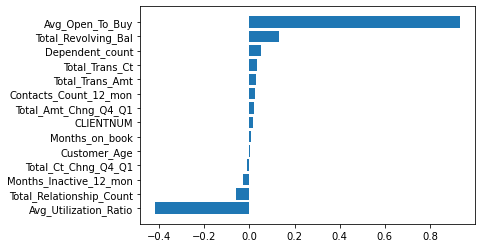

In [15]:
X = list(corr_target.keys())
y = list(corr_target.values())
plt.barh(X, y)
plt.gca().invert_yaxis()

Here we regard every variable as independent variable. However, it's not in fact. Variables always have some relationships with each other in real world.

In this plot, we can see 'Avg_Open_To_Buy' is the most correlated with credit limit. Other variables are less corelated with credit limit. Total_Trans_Ct and Total_Trans_Am are correlated so they have similar rankings in the plot.

## PCA

PCA means principle conponent analysis. We can use this technique to reduce dimensions and improve prediction.

We can see the importances of features computed by PCA. Scikit-learn has function PCA() for our use.

In [175]:
data = data.drop(['Credit_Limit'], axis=1)

In [17]:
pca = PCA()
pca.fit(data)
explained_variance = pca.explained_variance_ratio_

In [18]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[1.36188923e+15 8.30071783e+07 1.11724173e+07 6.58920305e+05
 1.90207834e+02 1.13117015e+02 1.29842254e+01 2.12447619e+00
 1.64247408e+00 1.18671258e+00 1.00783016e+00 7.08015874e-02
 3.12490905e-02 2.61943519e-02]
[9.99999930e-01 6.09500175e-08 8.20361618e-09 4.83828085e-10
 1.39664678e-13 8.30588891e-14 9.53397988e-15 1.55994775e-15
 1.20602610e-15 8.71372261e-16 7.40023539e-16 5.19877688e-17
 2.29453964e-17 1.92338330e-17]
[0.99999993 0.99999999 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


After fitting data by PCA, we can get explained variance, explained_variance ratio, and cumulative explained variance ratio of each feaure to understand feature importance better. Interestingly, one feature takes almost 100% explained variance ratio. We can notice it in later pages.

## mRMR

mRMR means maximum relevance minimum redundancy. It can be widely used even from marketing to genomics. In this project, we compute mRMR scores by using Spearman correlation.

By calling teh function spearman_mRMR, we can get scores of each feature. Sort the scores and plot a bar chart.

In [19]:
mRMR_dict = dict()

In [20]:
for col in data.columns:
    mRMR_dict[col] = spearman_mRMR(correlation, col)

In [21]:
mRMR_dict

{'CLIENTNUM': -0.0017130693764236572,
 'Customer_Age': -0.03424683868565139,
 'Dependent_count': 0.0690734484576738,
 'Months_on_book': -0.043435321026209936,
 'Total_Relationship_Count': -0.024989244348772248,
 'Months_Inactive_12_mon': -0.017964537807400538,
 'Contacts_Count_12_mon': 0.05976006611132534,
 'Total_Revolving_Bal': 0.07955164131718839,
 'Avg_Open_To_Buy': 0.9938364390324899,
 'Total_Amt_Chng_Q4_Q1': -0.013809599389622822,
 'Total_Trans_Amt': -0.03361743829338777,
 'Total_Trans_Ct': -0.02895761216045132,
 'Total_Ct_Chng_Q4_Q1': -0.06727122463946965,
 'Avg_Utilization_Ratio': -0.429881993004935}

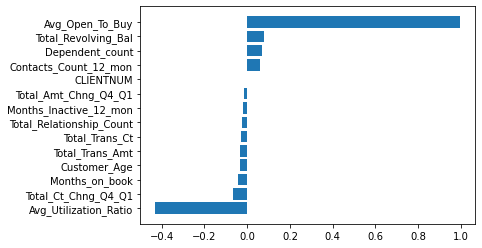

In [22]:
mRMR_dict = sorted(mRMR_dict.items(), key=lambda x: (x[1], x[0]), reverse = True)
mRMR_dict = dict(mRMR_dict)

X = list(mRMR_dict.keys())
y = list(mRMR_dict.values())
plt.barh(X, y)
plt.gca().invert_yaxis()

This result is similar to last result because we used Spearman correlation in mRMR formula. More features get a negative score and Total_Trans_Ct and Total_Trans_Am still have similar rankings in the plot.

## Permutation importance

Permutation importance means we can check importances by permuting each column. After permuting a column, we can see if the metric score increase or decrease. If increased, it proves dropping the columns is better, otherwise retaining the columns is better. This method is important for random forest particularly. More details are in: https://explained.ai/rf-importance/index.html. In the function implement for this project, I computed a baseline for all columns, then did baseline - metric score after permuting each column. So if baseline - metric score > 0, we shouldn't  drop that feature and that feature is important.

In [23]:
importance = permute_imp(data, target, LinearRegression(), mean_squared_error)

In [24]:
importance

{'CLIENTNUM': -4.251457796957366e-23,
 'Customer_Age': -5.683583130133956e-23,
 'Dependent_count': -3.675858390513098e-23,
 'Months_on_book': -3.3148319213478255e-23,
 'Total_Relationship_Count': -5.0599084437646537e-23,
 'Months_Inactive_12_mon': -5.380346515770288e-23,
 'Contacts_Count_12_mon': -4.825477659968853e-23,
 'Total_Revolving_Bal': 318445.5383567601,
 'Avg_Open_To_Buy': 60967939.628154725,
 'Total_Amt_Chng_Q4_Q1': 60986804.71291766,
 'Total_Trans_Amt': 62296697.263552584,
 'Total_Trans_Ct': 62493795.97657801,
 'Total_Ct_Chng_Q4_Q1': 62701177.68246261,
 'Avg_Utilization_Ratio': 83080372.66338082}

In [25]:
corr_permutation = sorted(importance.items(), key=lambda x: (x[1], x[0]), reverse = True)

In [26]:
corr_permutation = dict(corr_permutation)

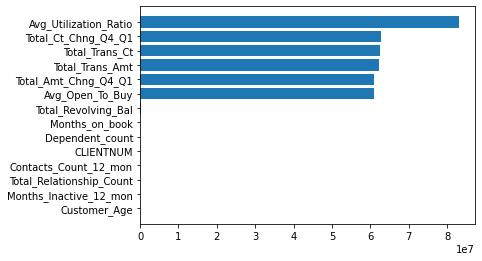

In [27]:
X = list(corr_permutation.keys())
y = list(corr_permutation.values())
plt.barh(X, y)
plt.gca().invert_yaxis()

The important features in this result are similar to Spearman correlation, but it has different extents and ranknings.

## Drop column importance

Drop column importance has almost same logistic as permutation importance. But we compare metric scores to baseline after dropping one feature. After dropping a feature, we can see if the metric score increase or decrease. If increased, it proves dropping the columns is better, otherwise retaining the columns is better. This method is important for random forest particularly. More details are in: https://explained.ai/rf-importance/index.html. In the function implement for this project, I computed a baseline for all columns, then did baseline - metric score after dropping each feature. So if baseline - metric score > 0, we shouldn't drop that feature and that feature is important.

In [28]:
importance = dropcolumn_imp(data, target, LinearRegression(), mean_squared_error)

In [29]:
importance

{'CLIENTNUM': -3.4307050840928293e-23,
 'Customer_Age': -2.735634524208531e-23,
 'Dependent_count': 1.1572000253262927e-23,
 'Months_on_book': -3.1503169865258046e-23,
 'Total_Relationship_Count': -2.287876065161518e-23,
 'Months_Inactive_12_mon': -2.3304140118892417e-23,
 'Contacts_Count_12_mon': -1.6798462588994552e-23,
 'Total_Revolving_Bal': 318191.16788221657,
 'Avg_Open_To_Buy': 48127819.53768757,
 'Total_Amt_Chng_Q4_Q1': 7.451790330916376e-23,
 'Total_Trans_Amt': 1.7644622379149626e-22,
 'Total_Trans_Ct': 3.2867945788505316e-23,
 'Total_Ct_Chng_Q4_Q1': -1.2565717756925633e-24,
 'Avg_Utilization_Ratio': 6.299282461838799e-23}

In [30]:
corr_dropcolumn = sorted(importance.items(), key=lambda x: (x[1], x[0]), reverse = True)

In [31]:
corr_dropcolumn = dict(corr_dropcolumn)

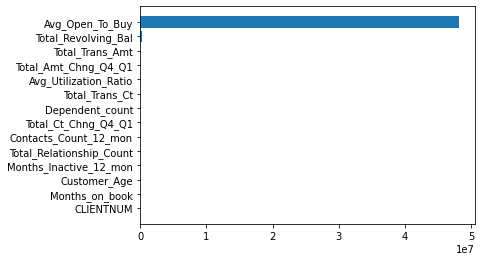

In [32]:
X = list(corr_dropcolumn.keys())
y = list(corr_dropcolumn.values())
plt.barh(X, y)
plt.gca().invert_yaxis()

This method gives us a more interesting result. Only 'Avg_Open_To_Buy' is very important to target and others are dispensable by contrast. It's same as the result of PCA saying just one feature take almost 100% explained variance ratio. But we can't conclude that we should only keep this one feature.

## Compare these methods

We can compare Spearman, mRMR, Permutation importance and Drop column importance by plotting metric scores of top k features of each method.

We can get feature importance rankings computed in previous parts, then compute metric scores by using top k features.

In [33]:
Spearman_ranking = list(corr_target.keys())

In [34]:
mRMR_ranking = list(mRMR_dict.keys())

In [35]:
permutation_ranking = list(corr_permutation.keys())

In [36]:
dropcolumn_ranking = list(corr_dropcolumn)

In [81]:
spearman_scores = compare(data, target, Spearman_ranking, 8, LinearRegression(), mean_squared_error)

In [82]:
spearman_scores

[1.1005615579195844e-16,
 9.711910832397183e-21,
 3.521164491281515e-19,
 3.984241618657886e-17,
 8.386967078776033e-19,
 1.9184694083109044e-17,
 3.926367857217172e-16,
 7.712550152439709e-17]

In [83]:
mRMR_scores = compare(data, target, mRMR_ranking, 8, LinearRegression(), mean_squared_error)
mRMR_scores

[7.729930660684557e-18,
 5.763642022533456e-16,
 1.8830215859505723e-17,
 9.886468430159458e-18,
 3.9771574667764244e-17,
 1.5138096481593164e-16,
 1.842633533206074e-18,
 4.077976037120051e-18]

In [84]:
permutation_scores = compare(data, target, permutation_ranking, 8, LinearRegression(), mean_squared_error)
permutation_scores 

[2.7174143694993445e-23,
 4.762285173338286e-24,
 3.303473466623693e-23,
 9.443500726548212e-24,
 1.3172417454610402e-22,
 3.015197858958564e-23,
 2.72114250028334e-23,
 5.104964441725375e-23]

In [85]:
dropcolumn_scores = compare(data, target, dropcolumn_ranking, 8, LinearRegression(), mean_squared_error)
dropcolumn_scores 

[6.70081621389082e-23,
 7.363818724793276e-23,
 2.866399253704393e-23,
 1.419766617904141e-22,
 4.243587606970894e-24,
 5.638834811406687e-23,
 1.5011904232158144e-22,
 1.0462592038534469e-22]

Get scores of each ranking then plot graphs. I used linear regresion as model and MSE as metric.

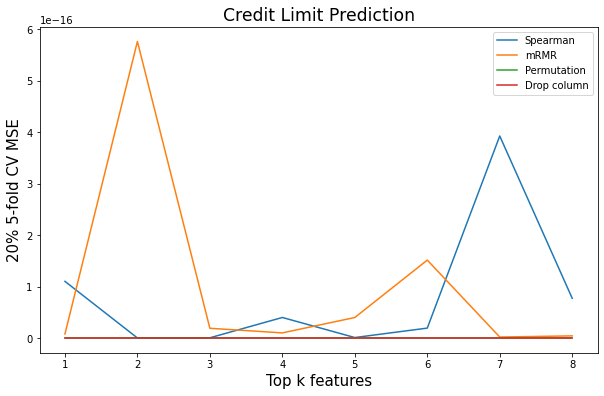

In [86]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(range(1,9), spearman_scores, label='Spearman')
plt.plot(range(1,9), mRMR_scores, label='mRMR')
plt.plot(range(1,9), permutation_scores, label='Permutation')
plt.plot(range(1,9), dropcolumn_scores, label='Drop column')
ax.set_xlabel("Top k features",fontsize="15")
ax.set_ylabel("20% 5-fold CV MSE",fontsize="15")
ax.set_title("Credit Limit Prediction",fontsize="xx-large")
plt.legend(loc="upper right")
plt.show()

We can see permutation and drop column have lower MSE scores and Spearman and mRMR have higher MSE scores. Spearman and mRMR are similar so their scores and trends are similar. But generally the trends are decreasing. Now we zoom in permutation and drop column methods that have lower MSE scores.

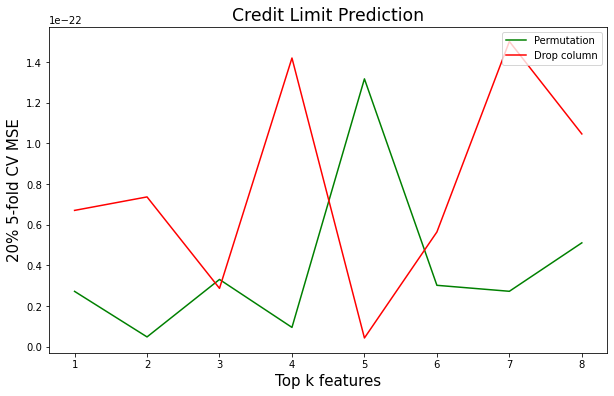

In [87]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(range(1,9), permutation_scores, label='Permutation', c='green')
plt.plot(range(1,9), dropcolumn_scores, label='Drop column', c='red')
ax.set_xlabel("Top k features",fontsize="15")
ax.set_ylabel("20% 5-fold CV MSE",fontsize="15")
ax.set_title("Credit Limit Prediction",fontsize="xx-large")
plt.legend(loc="upper right")
plt.show()

Permutation and drop column are similar in the trend, and we can see 3 features are best for this data and model.

## SHAP

SHAP can explain outputs of machine learning models. There's a developed libariry called shap. More details are on https://github.com/slundberg/shap. By using shap, we can get explanation information and do visualization. Here we can use a example code on https://github.com/slundberg/shap to do a visualization to compare to previoous parts.

In [96]:
model = LinearRegression().fit(data, target)

explainer = shap.Explainer(model)
shap_values = explainer(data)

shap.plots.waterfall(shap_values[0])

Exception: The passed model is not callable and cannot be analyzed directly with the given masker! Model: LinearRegression()

I used linear regression model but it failed. The example code on https://github.com/slundberg/shap is for tree ensemble models such as XGBoost, LightGBM and CatBoost so need more reasearch on the reason why it doesn't work for linear regression model.

So now we try XGBoost model.

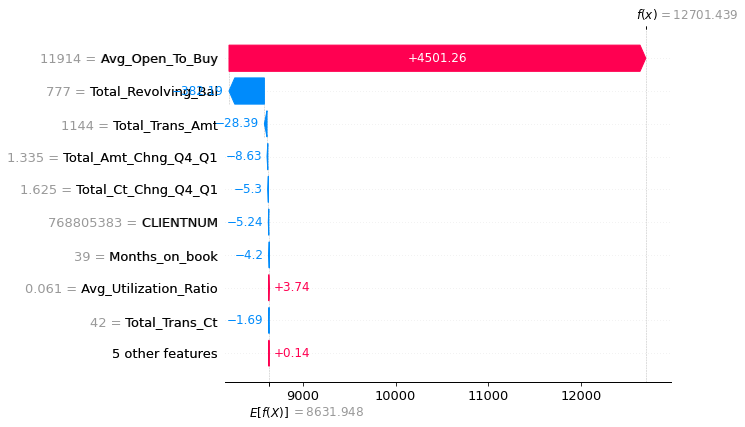

In [97]:
model = xgboost.XGBRegressor().fit(data, target)

explainer = shap.Explainer(model)
shap_values = explainer(data)

shap.plots.waterfall(shap_values[0])

This visualization gives a similar result to drop columns importance and PCA that almost only one feature 'Avg_Open_To_Buy' takes 100% importance.

## Automatic feature selection

We want to select features automatically so implemented feature_selection to do it. I used permutation importance to get feature importance in this function. In each time I drop the most unimportant feature and retrain the model, so we can recompute feature importance and get a new metric score. In this function, I also used linear regression as model and MSE as metric.

In [44]:
n, scores, columns_list = feature_selection(data, target, LinearRegression(), mean_squared_error)

In [45]:
scores

[1.0722305724320568e-22,
 1.9416454449285664e-17,
 7.386545190600598e-21,
 9.988291005644228e-20,
 4.0588575783290156e-23,
 1.082709401360515e-23,
 2.1958179964443278e-23,
 1.4841267609621678e-22,
 2.885955991780054e-23,
 1.1734068363061353e-23,
 2.3824720569897878e-23,
 4.1281610033547056e-23,
 3.225399620308069e-23,
 657505.9590686507]

We have 14 features in total. So after dropping one feature at one time, we got 14 MSE scores.

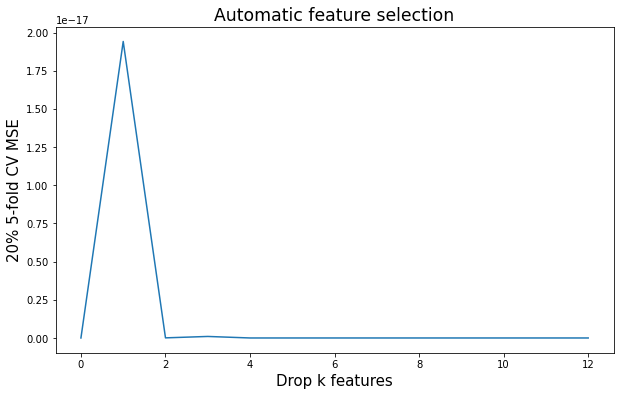

In [89]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(range(13), scores[:-1])
ax.set_xlabel("Drop k features",fontsize="15")
ax.set_ylabel("20% 5-fold CV MSE",fontsize="15")
ax.set_title("Automatic feature selection",fontsize="xx-large")
plt.show()

The MSE scores are fluctuating so it's hard to say we should stop once we see MSE score increases. So I computed all MSE scores after dropping all features. Except k = 1, MSE scores when k equals to other numbers are similar, so need more discussion and research to decide how to know whick k is best.

## Variance and p-values for feature importances

Here, we combine the knowledge of statistics to get mean and variance of feature importance, and p-value.

To compute variance and p-values, we need to compute model-based importance by bootstrapping X and y so we still use permutation importance here.

In [248]:
permute_importances = []
for i in range(10):
    rand_index = np.random.randint(0,10127,3000)
    bootstrap_x = data.iloc[rand_index]
    bootstrap_y = target.iloc[rand_index]
    permute_importance = permute_imp(bootstrap_x, bootstrap_y, LinearRegression(), mean_squared_error)
    permute_importances.append(permute_importance)

In this dataset, there are 10127 rows in total so we randomly pick 3000 rows in each iteration and 10 iterations in total. For each iteration, we compute a set of permutation importance of each feature. Fianlly, we have 10 sets of permutation importances in permute_importances.

After that, we need to split out 10 importances of each feature

In [249]:
importances_CLIENTNUM                = [x['CLIENTNUM'] for x in permute_importances]
importances_Customer_Age             = [x['Customer_Age'] for x in permute_importances]
importances_Dependent_count          = [x['Dependent_count'] for x in permute_importances]
importances_Months_on_book           = [x['Months_on_book'] for x in permute_importances]
importances_Total_Relationship_Count = [x['Total_Relationship_Count'] for x in permute_importances]
importances_Months_Inactive_12_mon   = [x['Months_Inactive_12_mon'] for x in permute_importances]
importances_Contacts_Count_12_mon    = [x['Contacts_Count_12_mon'] for x in permute_importances]
importances_Total_Revolving_Bal      = [x['Total_Revolving_Bal'] for x in permute_importances]
importances_Avg_Open_To_Buy          = [x['Avg_Open_To_Buy'] for x in permute_importances]
importances_Total_Amt_Chng_Q4_Q1     = [x['Total_Amt_Chng_Q4_Q1'] for x in permute_importances]
importances_Total_Trans_Amt          = [x['Total_Trans_Amt'] for x in permute_importances]
importances_Total_Trans_Ct           = [x['Total_Trans_Ct'] for x in permute_importances]
importances_Total_Ct_Chng_Q4_Q1      = [x['Total_Ct_Chng_Q4_Q1'] for x in permute_importances]
importances_Avg_Utilization_Ratio    = [x['Avg_Utilization_Ratio'] for x in permute_importances]

Because we want to plot mean and mean +/- 2 * deviation, we need to compute importance means of each feature.

In [250]:
means = [np.mean(importances_CLIENTNUM), np.mean(importances_Customer_Age), np.mean(importances_Dependent_count ), np.mean(importances_Months_on_book ), 
         np.mean(importances_Total_Relationship_Count), np.mean(importances_Months_Inactive_12_mon), np.mean(importances_Contacts_Count_12_mon), 
         np.mean(importances_Total_Revolving_Bal ), np.mean(importances_Avg_Open_To_Buy), np.mean(importances_Total_Amt_Chng_Q4_Q1), np.mean(importances_Total_Trans_Amt), 
         np.mean(importances_Total_Trans_Ct), np.mean(importances_Total_Ct_Chng_Q4_Q1), np.mean(importances_Avg_Utilization_Ratio)]

So we can plot the bar chart that contains mean and mean +/- 2 * deviation of each features.

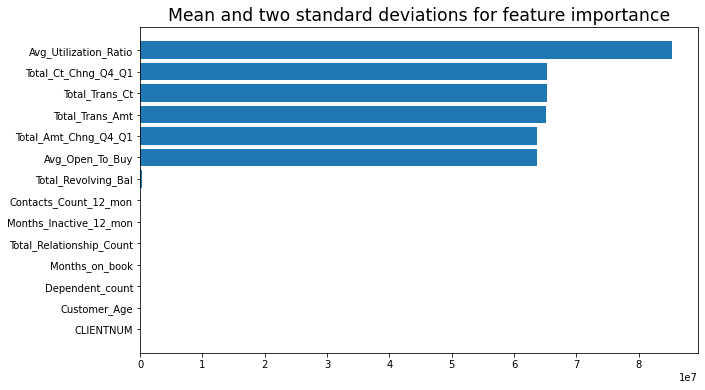

In [261]:
fig, ax = plt.subplots(figsize=(10,6))
plt.barh(list(permute_importances[0].keys()), means)
plt.axhline(y=13, xmin=means[-1]-2*np.std(importances_Avg_Utilization_Ratio), xmax=means[-1]+2*np.std(importances_Avg_Utilization_Ratio), c='black')
plt.axhline(y=12, xmin=means[-2]-2*np.std(importances_Total_Ct_Chng_Q4_Q1),   xmax=means[-2]+2*np.std(importances_Total_Ct_Chng_Q4_Q1),   c='black')
plt.axhline(y=11, xmin=means[-3]-2*np.std(importances_Total_Trans_Ct),        xmax=means[-2]+2*np.std(importances_Total_Trans_Ct ),       c='black')
plt.axhline(y=10, xmin=means[-4]-2*np.std(importances_Total_Trans_Amt),       xmax=means[-2]+2*np.std(importances_Total_Trans_Amt),       c='black')
plt.axhline(y=9,  xmin=means[-5]-2*np.std(importances_Total_Amt_Chng_Q4_Q1),  xmax=means[-2]+2*np.std(importances_Total_Amt_Chng_Q4_Q1),  c='black')
plt.axhline(y=8,  xmin=means[-6]-2*np.std(importances_Avg_Open_To_Buy),       xmax=means[-2]+2*np.std(importances_Avg_Open_To_Buy),       c='black')
plt.axhline(y=7,  xmin=means[-7]-2*np.std(importances_Total_Revolving_Bal),   xmax=means[-2]+2*np.std(importances_Total_Revolving_Bal),   c='black')
ax.set_title("Mean and two standard deviations for feature importance",fontsize="xx-large")
plt.show()

However, for this dataset only two stantard deviations look not obvious. It possibly could prove that the variance of feature importance of this dataset is small.

## Next things:

- Figure out the reason why can't use linear regression model for SHAP
- Try another dataset to check explained variance ratio of PCA again
- Try another dataset to check standard deviations of feature importance and p-values because this dataset is not obvious so not so meaningful